In [1]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, center_crop, normalize_separate_over_ch, rss_torch,to_tensor
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


In [2]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E11/E11.12_joint(l1_1e-5)P_T300_300epoch/E11.12_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
# '/cheng/metaMRI/metaMRI/save/E13.1_sup(l1_1e-5)P_T300_300epoch/E13.1_sup(l1_1e-5)P_T300_300epoch_E300.pth'
# '/cheng/metaMRI/metaMRI/save/E11/E11.12_joint(l1_1e-5)P_T300_300epoch/E11.12_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11/E11.11_joint(l1_1e-5)P_T300_300epoch/E11.11_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'

model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

In [3]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_val.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_val/'

# path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_test_100.yaml'
# path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_test/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [4]:
path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/test_data/anatomy_shift/mask2d'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)


iterator = iter(test_dataloader)
batch = next(iterator)

origk, sens_maps, sens_maps_conj, binary_background_mask, fname, slice_num = batch

scaled_noise = origk * torch.randn(origk.size())
scaled_noise = scaled_noise.squeeze(0).to(device)

origk = origk.squeeze(0).to(device)
sens_maps = sens_maps.squeeze(0).to(device)
sens_maps_conj = sens_maps_conj.squeeze(0).to(device)
binary_background_mask = binary_background_mask.to(device)

In [5]:
background_flip = False
eval_with_binary_mask = True

ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')
adapt_lr = 0.00001


Standard TTT

In [6]:
TTT_epoch = 1500

# input k space
input_kspace = origk * mask + 0.0   # [coils,height,width,2]

# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)

# gt image by normalized kspace: x
target_image_1c = rss_torch(complex_abs(ifft2c(origk))).unsqueeze(0)
# sensmap combine
# target_image = complex_mul(target_image, sens_maps_conj).sum(dim=0, keepdim=False)
crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
crop_target_image = center_crop( target_image_1c, crop_size )
std_crop_target_image = crop_target_image.std()
mean_crop_target_image = crop_target_image.mean()

binary_mask_target_image_1c = (target_image_1c.unsqueeze(0) * binary_background_mask).squeeze(0)
crop_binary_mask_target_image_1c = center_crop( binary_mask_target_image_1c, crop_size )

loss_l1_history = []
loss_ssim_history = []
self_loss_history = []

model_ttt = copy.deepcopy(model)
optimizer = torch.optim.Adam(model_ttt.parameters(),lr=adapt_lr)

for iteration in range(TTT_epoch): 
    ###### training ######
    # fθ(A†y)
    model_output = model_ttt(train_inputs.unsqueeze(0))    # [1, 2, height, width]  
    model_output = model_output.squeeze(0) * std + mean     
    model_output = torch.moveaxis(model_output.unsqueeze(0), 1, -1 )    #[1, height, width, 2]

    # S fθ(A†y) [coils, height, width, channel]
    if background_flip == True: 
        output_sens_image = torch.zeros(sens_maps.shape).to(device) 
        for j,s in enumerate(sens_maps):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
            output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]

    else: 
        output_sens_image = complex_mul(model_output, sens_maps)
    # FS fθ(A†y)
    Fimg = fft2c(output_sens_image)
    # MFS fθ(A†y) = A fθ(A†y)
    Fimg_forward = Fimg * mask
    # consistency loss [y, Afθ(A†y)]
    loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

    optimizer.zero_grad()
    loss_self.backward()
    optimizer.step()
    #train_loss += loss.item()
    #print('TTT loss: ',loss_self.item())
    self_loss_history.append(loss_self.item())

    ###### evaluation ######
    output_image_1c = complex_abs(model_output).unsqueeze(0)    # [2, height, width] -> [1, height, width]
    if eval_with_binary_mask == True: 
        binary_mask_output_image_1c = (output_image_1c.unsqueeze(0) * binary_background_mask).squeeze(0)
        # center crop for SSIM
        crop_output_image = center_crop( binary_mask_output_image_1c, crop_size )
    else: 
        # center crop for SSIM
        crop_output_image = center_crop( output_image_1c, crop_size )
    # normalization
    crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
    crop_output_image *= std_crop_target_image
    crop_output_image += mean_crop_target_image
    # SSIM = 1 - loss
    loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
    print(f"Epoch {iteration+1}/{TTT_epoch}, Training Self-Loss: {loss_self.item():.4f}, SSIM: {loss_ssim:.4f}", end='\r')

    #loss_l1_history.append(loss_l1)
    loss_ssim_history.append(loss_ssim)

# best results for an example
# best_loss_l1 = min(loss_l1_history)
# print('The best L1: ', best_loss_l1)
# best_loss_l1_epoch = np.argmin(loss_l1_history)
# print('The best L1 epoch: ', best_loss_l1_epoch)
best_loss_ssim = max(loss_ssim_history)
print('The best SSIM through training process:', best_loss_ssim)
best_loss_ssim_epoch = np.argmax(loss_ssim_history)
print('The best SSIM epoch: ', best_loss_ssim_epoch)

The best SSIM through training process: 0.9431825280189514
The best SSIM epoch:  1429


Initialization

In [7]:
TTT_epoch = 1500
optimizer = torch.optim.Adam(model.parameters(),lr=adapt_lr)

# input k space
input_kspace = scaled_noise * mask + 0.0   # [coils,height,width,2]

# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)
train_inputs_bgmask = train_inputs.unsqueeze(0) * binary_background_mask

#input_kspace = fft2c(complex_mul(torch.moveaxis(train_inputs_bgmask, 1, -1), sens_maps))



for iteration in range(TTT_epoch): 
    ###### training ######
    # fθ(A†y)
    model_output = model(train_inputs_bgmask)    # [1, 2, height, width]  
    model_output = model_output.squeeze(0) * std + mean     
    model_output = torch.moveaxis(model_output.unsqueeze(0), 1, -1 )    #[1, height, width, 2]

    # S fθ(A†y) [coils, height, width, channel]
    if background_flip == True: 
        output_sens_image = torch.zeros(sens_maps.shape).to(device) 
        for j,s in enumerate(sens_maps):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
            output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]

    else: 
        output_sens_image = complex_mul(model_output, sens_maps)
    # FS fθ(A†y)
    Fimg = fft2c(output_sens_image)
    # MFS fθ(A†y) = A fθ(A†y)
    Fimg_forward = Fimg * mask
    # consistency loss [y, Afθ(A†y)]
    loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

    optimizer.zero_grad()
    loss_self.backward()
    optimizer.step()

    # SSIM = 1 - loss
    print(f"Epoch {iteration+1}/{TTT_epoch}, Training Self-Loss: {loss_self.item():.4f}", end='\r')

In [8]:
TTT_epoch = 1500

# input k space
input_kspace = origk * mask + 0.0   # [coils,height,width,2]

# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)

# gt image by normalized kspace: x
target_image_1c = rss_torch(complex_abs(ifft2c(origk))).unsqueeze(0)
# sensmap combine
# target_image = complex_mul(target_image, sens_maps_conj).sum(dim=0, keepdim=False)
crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
crop_target_image = center_crop( target_image_1c, crop_size )
std_crop_target_image = crop_target_image.std()
mean_crop_target_image = crop_target_image.mean()

binary_mask_target_image_1c = (target_image_1c.unsqueeze(0) * binary_background_mask).squeeze(0)
crop_binary_mask_target_image_1c = center_crop( binary_mask_target_image_1c, crop_size )

#loss_l1_history_plus = []
loss_ssim_history_plus = []
self_loss_history_plus = []

for iteration in range(TTT_epoch): 
    ###### training ######
    # fθ(A†y)
    model_output = model(train_inputs.unsqueeze(0))    # [1, 2, height, width]  
    model_output = model_output.squeeze(0) * std + mean     
    model_output = torch.moveaxis(model_output.unsqueeze(0), 1, -1 )    #[1, height, width, 2]

    # S fθ(A†y) [coils, height, width, channel]
    if background_flip == True: 
        output_sens_image = torch.zeros(sens_maps.shape).to(device) 
        for j,s in enumerate(sens_maps):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
            output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]

    else: 
        output_sens_image = complex_mul(model_output, sens_maps)
    # FS fθ(A†y)
    Fimg = fft2c(output_sens_image)
    # MFS fθ(A†y) = A fθ(A†y)
    Fimg_forward = Fimg * mask
    # consistency loss [y, Afθ(A†y)]
    loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

    optimizer.zero_grad()
    loss_self.backward()
    optimizer.step()
    #train_loss += loss.item()
    #print('TTT loss: ',loss_self.item())
    self_loss_history_plus.append(loss_self.item())

    ###### evaluation ######
    output_image_1c = complex_abs(model_output).unsqueeze(0)    # [2, height, width] -> [1, height, width]
    if eval_with_binary_mask == True: 
        binary_mask_output_image_1c = (output_image_1c.unsqueeze(0) * binary_background_mask).squeeze(0)
        # center crop for SSIM
        crop_output_image = center_crop( binary_mask_output_image_1c, crop_size )
    else: 
        # center crop for SSIM
        crop_output_image = center_crop( output_image_1c, crop_size )
    # normalization
    crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
    crop_output_image *= std_crop_target_image
    crop_output_image += mean_crop_target_image
    # SSIM = 1 - loss
    loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
    print(f"Epoch {iteration+1}/{TTT_epoch}, Training Self-Loss: {loss_self.item():.4f}, SSIM: {loss_ssim:.4f}", end='\r')

    #loss_l1_history.append(loss_l1)
    loss_ssim_history_plus.append(loss_ssim)

# best results for an example
# best_loss_l1 = min(loss_l1_history)
# print('The best L1: ', best_loss_l1)
# best_loss_l1_epoch = np.argmin(loss_l1_history)
# print('The best L1 epoch: ', best_loss_l1_epoch)
best_loss_ssim_plus = max(loss_ssim_history_plus)
print('The best SSIM through training process:', best_loss_ssim_plus)
best_loss_ssim_epoch_plus = np.argmax(loss_ssim_history_plus)
print('The best SSIM epoch: ', best_loss_ssim_epoch_plus)

The best SSIM through training process: 0.9439291954040527
The best SSIM epoch:  1304


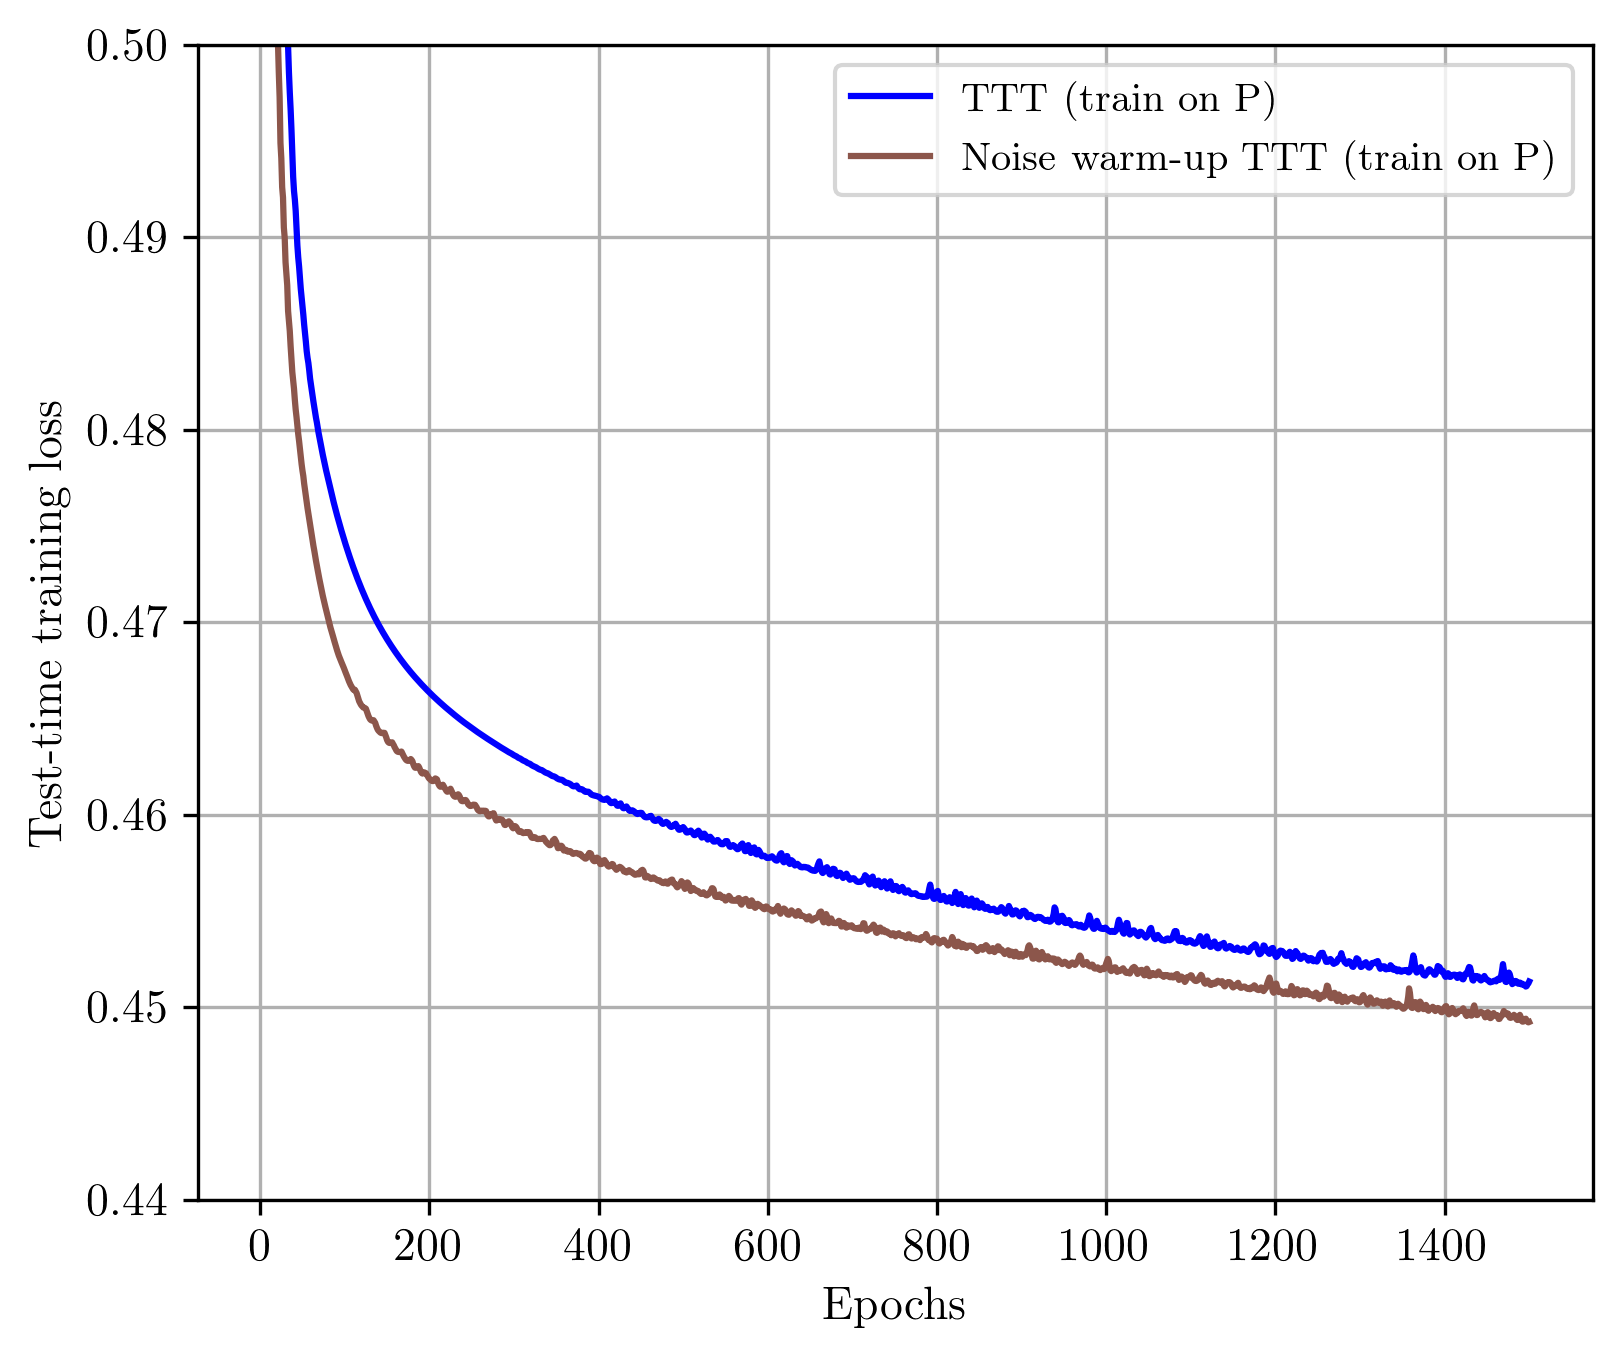

In [40]:
plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), self_loss_history, color=colors[0], label='TTT (train on P)')
plt.plot(range(1, TTT_epoch+1), self_loss_history_plus, color=colors[6], label='Noise warm-up TTT (train on P)')

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Test-time training loss',fontsize=FONTSIZE/2)
plt.ylim(0.44, 0.5)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

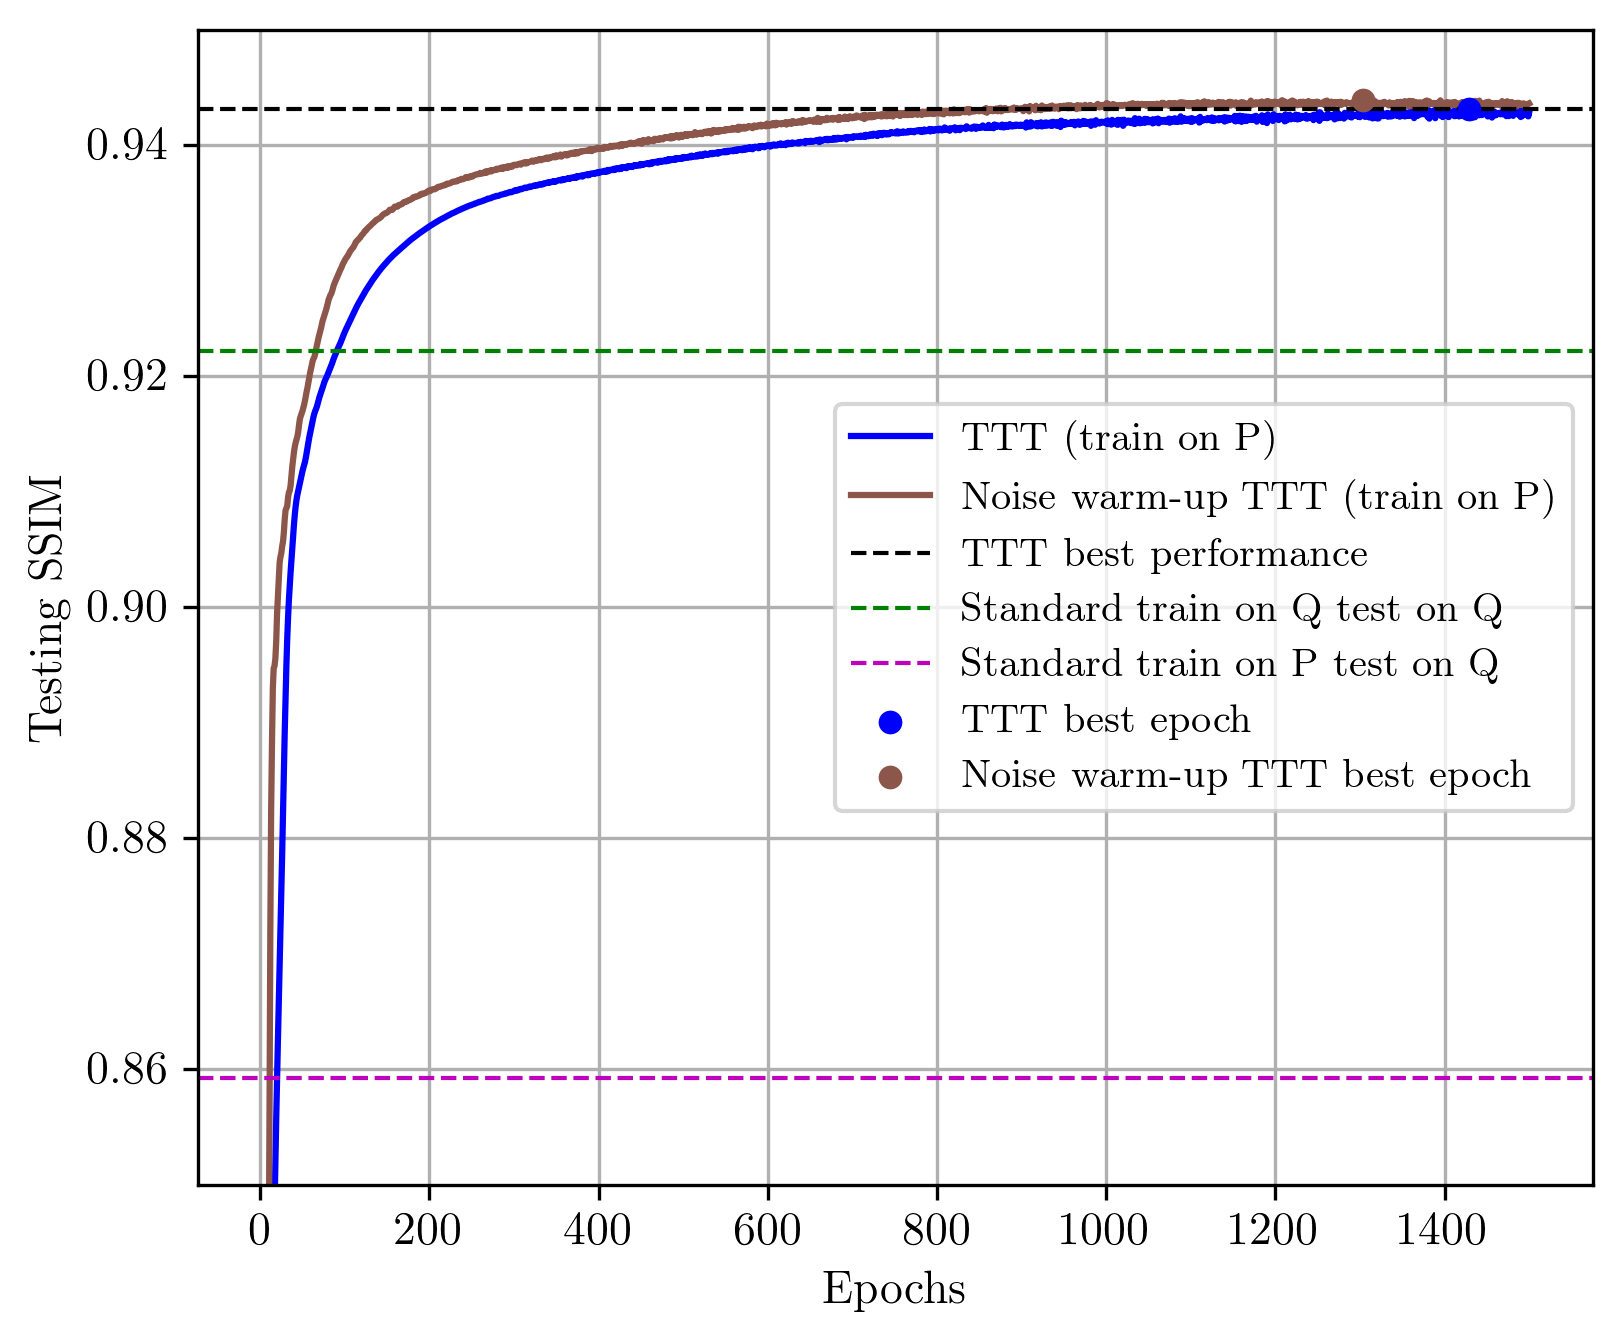

In [39]:
TTT_epoch = 1500
upper_bound = 0.9222 # not real
lower_bound = 0.8593 # not real

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_epoch+1), loss_ssim_history, color=colors[0], label='TTT (train on P)')
plt.plot(range(1, TTT_epoch+1), loss_ssim_history_plus, color=colors[6], label='Noise warm-up TTT (train on P)')

plt.axhline(y = loss_ssim_history[best_loss_ssim_epoch], color=colors[2], label='TTT best performance', linestyle='--', linewidth=1)  
plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ', linewidth=1)   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ', linewidth=1)   # upper bound

plt.scatter(best_loss_ssim_epoch, loss_ssim_history[best_loss_ssim_epoch], color=colors[0], s=FONTSIZE, label = 'TTT best epoch', zorder=2)
plt.scatter(best_loss_ssim_epoch_plus, loss_ssim_history_plus[best_loss_ssim_epoch_plus], color=colors[6], s=FONTSIZE, label = 'Noise warm-up TTT best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.ylim(0.85, 0.95)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

In [10]:
input_kspace = origk * mask + 0.0   # [coils,height,width,2]
# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)
crop_input_image = center_crop( complex_abs(torch.moveaxis(train_inputs.unsqueeze(0), 1, -1 )), crop_size )

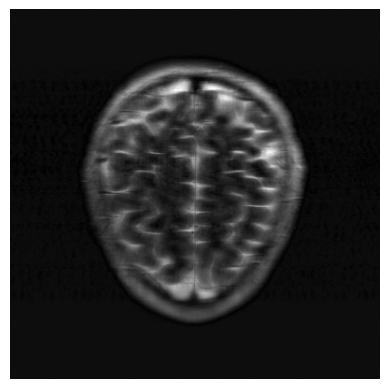

In [11]:
plt.imshow(crop_input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

In [12]:
input_kspace = scaled_noise * mask + 0.0   # [coils,height,width,2]
# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)
crop_input_image = center_crop( complex_abs(torch.moveaxis(train_inputs.unsqueeze(0), 1, -1 )), crop_size )

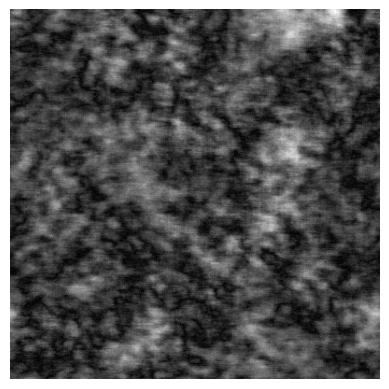

In [13]:
plt.imshow(crop_input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

In [14]:
binary_background_mask.shape

torch.Size([1, 1, 768, 396])

In [15]:
input_kspace = scaled_noise * mask + 0.0   # [coils,height,width,2]
# A†y
train_inputs = torch.moveaxis(rss_torch(ifft2c(input_kspace)), -1, 0)   # [2, height, width]
train_inputs, mean, std = normalize_separate_over_ch(train_inputs, eps=1e-11)

train_inputs = complex_abs(torch.moveaxis(train_inputs.unsqueeze(0), 1, -1 )) * binary_background_mask
crop_input_image = center_crop(train_inputs, crop_size )

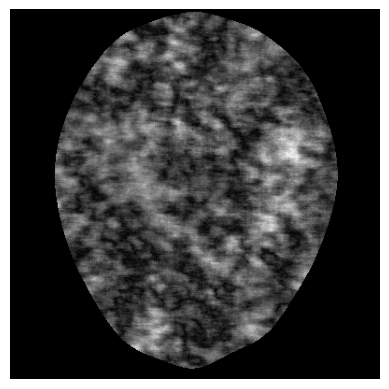

In [16]:
plt.imshow(crop_input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()